In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])

In [2]:
# 1. Customer Split (95%/5%)
# --------------------------

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

# Split data
df_train = df_quotes[df_quotes['numero_compte'].isin(train_cust)].copy()
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

print(f"Split: {len(train_cust)} train, {len(sim_cust)} sim customers")

Split: 22708 train, 1180 sim customers


In [3]:
# 1. CUSTOMER SPLIT (95%/5%) - REVISED WITH DEBUGGING
print("=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===")

# First quote per customer
cust_first = df_quotes.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
cust_first = cust_first.sort_values('dt_creation_devis')

# Check total customers
print(f"Total unique customers: {len(cust_first)}")

# 95th percentile split
split_idx = int(len(cust_first) * 0.95)
split_date = cust_first.iloc[split_idx]['dt_creation_devis']

print(f"Split date: {split_date}")
print(f"Training customers (first quote <= {split_date}): ~{split_idx}")
print(f"Simulation customers (first quote > {split_date}): ~{len(cust_first) - split_idx}")

# Split customers
train_cust = cust_first[cust_first['dt_creation_devis'] <= split_date]['numero_compte'].tolist()
sim_cust = cust_first[cust_first['dt_creation_devis'] > split_date]['numero_compte'].tolist()

print(f"Actual split: {len(train_cust)} train, {len(sim_cust)} sim customers")

=== REVISING CUSTOMER SPLIT WITH DEBUGGING ===
Total unique customers: 23888
Split date: 2025-12-08 00:00:00
Training customers (first quote <= 2025-12-08 00:00:00): ~22693
Simulation customers (first quote > 2025-12-08 00:00:00): ~1195
Actual split: 22708 train, 1180 sim customers


In [4]:
# 2. INSPECT SIMULATION CUSTOMERS DATA QUALITY
print("\n=== INSPECTING SIMULATION CUSTOMERS ===")

# Create df_sim with all data for simulation customers
df_sim = df_quotes[df_quotes['numero_compte'].isin(sim_cust)].copy()

# Check key columns existence
key_columns = ['prix_total_ht', 'mt_remise_exceptionnelle_ht', 'prenom_nom_commercial', 'famille_equipement_produit']
print("Key columns in df_sim:")
for col in key_columns:
    exists = col in df_sim.columns
    print(f"  {col}: {'✓' if exists else '✗'}")

# Check non-converted customers
sim_conv = df_sim.groupby('numero_compte')['fg_devis_accepte'].max()
non_conv_count = (sim_conv == 0).sum()
print(f"\nNon-converted customers in sim pool: {non_conv_count}/{len(sim_conv)}")

# Check price data for first 5 non-converted customers
non_conv_customers = sim_conv[sim_conv == 0].index.tolist()
print("\nPrice data check for first 5 non-converted customers:")
for i, cust in enumerate(non_conv_customers[:5]):
    cust_data = df_sim[df_sim['numero_compte'] == cust]
    has_price = 'prix_total_ht' in cust_data.columns and cust_data['prix_total_ht'].notna().any()
    price_sum = cust_data['prix_total_ht'].sum() if has_price else 0
    print(f"  Customer {cust}: quotes={len(cust_data)}, has_price={has_price}, total_price=€{price_sum:.2f}")


=== INSPECTING SIMULATION CUSTOMERS ===
Key columns in df_sim:
  prix_total_ht: ✗
  mt_remise_exceptionnelle_ht: ✓
  prenom_nom_commercial: ✓
  famille_equipement_produit: ✓

Non-converted customers in sim pool: 923/1180

Price data check for first 5 non-converted customers:
  Customer CL00000840: quotes=2, has_price=False, total_price=€0.00
  Customer CL00002004: quotes=1, has_price=False, total_price=€0.00
  Customer CL00002625: quotes=1, has_price=False, total_price=€0.00
  Customer CL00005945: quotes=2, has_price=False, total_price=€0.00
  Customer CL00063542: quotes=1, has_price=False, total_price=€0.00


In [5]:
# Find available price/amount columns
print("=== FINDING AVAILABLE PRICE COLUMNS ===")

price_columns = [col for col in df_sim.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"Found {len(price_columns)} price-related columns:")
for col in sorted(price_columns):
    sample_val = df_sim[col].dropna().iloc[0] if not df_sim[col].dropna().empty else "N/A"
    print(f"  - {col}: sample = {sample_val}")

# Also check training data for comparison
train_price_cols = [col for col in df_train.columns if any(term in col.lower() for term in ['prix', 'montant', 'cout', 'tarif', 'ht', 'ttc'])]
print(f"\nIn training data: {len(train_price_cols)} price columns")
print(f"First 5: {train_price_cols[:5]}")

=== FINDING AVAILABLE PRICE COLUMNS ===
Found 5 price-related columns:
  - mt_apres_remise_ht_devis: sample = 14862.73
  - mt_apres_remise_ht_emis_devis: sample = 7431.365
  - mt_remise_exceptionnelle_ht: sample = -1500.0
  - mt_ttc_apres_aide_devis: sample = 6680.19
  - mt_ttc_avant_aide_devis: sample = 15680.19

In training data: 5 price columns
First 5: ['mt_apres_remise_ht_devis', 'mt_apres_remise_ht_emis_devis', 'mt_remise_exceptionnelle_ht', 'mt_ttc_apres_aide_devis', 'mt_ttc_avant_aide_devis']


In [6]:
# 2. Model Training (Silent)
# --------------------------
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
import sys
import os

# Suppress create_features output
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Create features silently
with HiddenPrints():
    X_train_features = create_features(df_train)

# Prepare target
if 'converted' not in X_train_features.columns:
    if 'fg_devis_accepte' in X_train_features.columns:
        X_train_features['converted'] = (X_train_features['fg_devis_accepte'] == 1).astype(int)
    else:
        # Calculate from raw data
        cust_conv = df_train.groupby('numero_compte')['fg_devis_accepte'].max().reset_index()
        cust_conv.columns = ['numero_compte', 'converted']
        X_train_features = pd.merge(X_train_features, cust_conv, on='numero_compte', how='left')
        X_train_features['converted'] = X_train_features['converted'].fillna(0).astype(int)

y_train = X_train_features['converted']

# Prepare features
exclude = ['numero_compte', 'converted'] + \
          [c for c in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum'] 
           if c in X_train_features.columns]

X_train = X_train_features.drop(exclude, axis=1)
feature_names = X_train.columns.tolist()

# Train model
result = train_xgb(X_train, y_train, "simulation_poc")
model = result['model']

print(f"Model trained: {len(feature_names)} features")

✓ Model saved: simulation_poc.pkl
✓ AUC: 0.729
✓ F1 Score: 0.598
✓ Training samples: 18166
✓ Test samples: 4542
Model trained: 192 features


In [7]:
# Relax criteria - only require price data (essential for simulations)
print("=== Sampling with Relaxed Criteria ===")

eligible_candidates = []
for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # ESSENTIAL: Must have price data for discount scenarios
    has_price = 'prix_total_ht' in cust_quotes.columns and cust_quotes['prix_total_ht'].notna().any() and cust_quotes['prix_total_ht'].sum() > 0
    
    # NICE TO HAVE (not required): sales rep and product data
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    has_product = 'famille_equipement_produit' in cust_quotes.columns and cust_quotes['famille_equipement_produit'].notna().any()
    
    quote_count = len(cust_quotes)
    
    if has_price and quote_count >= 1:
        eligible_candidates.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'has_price': has_price,
            'has_rep': has_rep,
            'has_product': has_product,
            'total_price': cust_quotes['prix_total_ht'].sum()
        })

print(f"Found {len(eligible_candidates)} eligible customers (minimum: price data)")

=== Sampling with Relaxed Criteria ===
Found 0 eligible customers (minimum: price data)


In [8]:
# UPDATE: Select valid simulation customers with BOTH price AND sales rep data
print("=== UPDATING FOR SCENARIO 2: PRICE + SALES REP DATA ===")

# Select valid simulation customers (with price AND rep data)
valid_sim_customers = []

for cust in non_conv_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust]
    
    # Check if customer has valid price data
    has_price = 'mt_apres_remise_ht_devis' in cust_quotes.columns and cust_quotes['mt_apres_remise_ht_devis'].notna().any()
    price_value = cust_quotes['mt_apres_remise_ht_devis'].sum() if has_price else 0
    
    # Check if customer has a sales rep (REQUIRED for Scenario 2)
    has_rep = 'prenom_nom_commercial' in cust_quotes.columns and cust_quotes['prenom_nom_commercial'].notna().any()
    
    quote_count = len(cust_quotes)
    
    # Now require BOTH price AND rep data
    if has_price and has_rep and quote_count >= 1 and price_value > 0:
        valid_sim_customers.append({
            'customer_id': cust,
            'quote_count': quote_count,
            'total_price': price_value,
            'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0],
            'has_rep': has_rep
        })

print(f"Found {len(valid_sim_customers)} valid simulation customers (with price + rep data)")
print("\nFirst 5 valid customers:")
for cust in valid_sim_customers[:5]:
    print(f"  {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f}, rep: {cust['current_rep']}")

=== UPDATING FOR SCENARIO 2: PRICE + SALES REP DATA ===
Found 923 valid simulation customers (with price + rep data)

First 5 valid customers:
  CL00000840: 2 quotes, €17363.41, rep: Anthony BONNESOEUR
  CL00002004: 1 quotes, €14286.47, rep: Lucas DONATI
  CL00002625: 1 quotes, €14512.23, rep: Lucas DONATI
  CL00005945: 2 quotes, €14909.04, rep: Lucas DONATI
  CL00063542: 1 quotes, €5542.11, rep: Florian LEMOINE


In [9]:
# STEP 3.2: STRATEGIC SAMPLING - PRESERVE ALL VARIABLE NAMES
print("\n=== STRATEGIC SAMPLING FOR ALL SCENARIOS ===")

# Convert valid_sim_customers list to DataFrame
valid_df = pd.DataFrame(valid_sim_customers)

# Add current discount information
valid_df['current_discount'] = 0
valid_df['discount_pct'] = 0

for idx, row in valid_df.iterrows():
    cust_quotes = df_sim[df_sim['numero_compte'] == row['customer_id']]
    if 'mt_remise_exceptionnelle_ht' in cust_quotes.columns:
        current_discount = abs(cust_quotes['mt_remise_exceptionnelle_ht'].sum())
        valid_df.loc[idx, 'current_discount'] = current_discount
        if row['total_price'] > 0:
            valid_df.loc[idx, 'discount_pct'] = (current_discount / row['total_price'] * 100)

print(f"Available customers: {len(valid_df)}")

# Find top rep from training data (for rep scenario)
rep_stats = df_train.groupby('prenom_nom_commercial').agg({
    'fg_devis_accepte': ['count', 'mean']
}).round(3)
rep_stats.columns = ['quote_count', 'conversion_rate']
rep_stats = rep_stats[rep_stats['quote_count'] >= 20]
rep_stats = rep_stats.sort_values('conversion_rate', ascending=False)
top_rep = rep_stats.index[0]

# Add rep performance to valid_df
rep_performance = rep_stats['conversion_rate'].to_dict()
valid_df['rep_performance'] = valid_df['current_rep'].map(rep_performance)
valid_df['rep_performance'] = valid_df['rep_performance'].fillna(rep_stats['conversion_rate'].median())

# Apply strategic sampling - PRESERVE ALL VARIABLE NAMES
import random
random.seed(42)

selected = []  # MUST KEEP THIS VARIABLE NAME

# 1. No existing discount (for discount scenario)
no_discount = valid_df[valid_df['current_discount'] == 0]
if len(no_discount) > 0:
    selected.append(no_discount.sample(1).iloc[0].to_dict())
    print(f"✓ Sampled no-discount customer: {selected[-1]['customer_id']}")

# 2. Small existing discount (for discount scenario)
small_discount = valid_df[(valid_df['discount_pct'] > 0) & (valid_df['discount_pct'] < 2)]
if len(small_discount) > 0:
    # Ensure not already selected
    available = small_discount[~small_discount['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled small-discount customer: {selected[-1]['customer_id']}")

# 3. Different rep than top rep (for rep scenario)
diff_rep = valid_df[valid_df['current_rep'] != top_rep]
if len(diff_rep) > 0:
    available = diff_rep[~diff_rep['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled different-rep customer: {selected[-1]['customer_id']} (rep: {selected[-1]['current_rep']})")

# 4. High price (for discount scenario)
high_price = valid_df[valid_df['total_price'] > 20000]
if len(high_price) > 0:
    available = high_price[~high_price['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled high-price customer: {selected[-1]['customer_id']}")

# 5. Multiple quotes (good for both scenarios)
multi_quote = valid_df[valid_df['quote_count'] >= 2]  # Changed from 3 to 2 for more candidates
if len(multi_quote) > 0:
    available = multi_quote[~multi_quote['customer_id'].isin([s['customer_id'] for s in selected])]
    if len(available) > 0:
        selected.append(available.sample(1).iloc[0].to_dict())
        print(f"✓ Sampled multi-quote customer: {selected[-1]['customer_id']}")

# If we have less than 5, fill with random from remaining
if len(selected) < 5:
    remaining = valid_df[~valid_df['customer_id'].isin([s['customer_id'] for s in selected])]
    needed = 5 - len(selected)
    if len(remaining) >= needed:
        additional = remaining.sample(needed)
        for _, row in additional.iterrows():
            selected.append(row.to_dict())
            print(f"✓ Added random customer: {row['customer_id']}")

print(f"\n✓ Strategically sampled {len(selected)} diverse customers")
print("\nSelected customers:")
for i, cust in enumerate(selected, 1):
    print(f"{i}. {cust['customer_id']}: {cust['quote_count']} quotes, €{cust['total_price']:.2f}, "
          f"discount={cust['discount_pct']:.1f}%, rep={cust['current_rep']}")

# MUST KEEP THIS VARIABLE NAME FOR REST OF NOTEBOOK
selected_ids = [cust['customer_id'] for cust in selected]
print(f"\nSelected IDs: {selected_ids}")


=== STRATEGIC SAMPLING FOR ALL SCENARIOS ===
Available customers: 923
✓ Sampled no-discount customer: CL00345355
✓ Sampled small-discount customer: CL00345097
✓ Sampled different-rep customer: CL00340543 (rep: FREDDY VEZILIER)
✓ Sampled high-price customer: CL00340494
✓ Sampled multi-quote customer: CL00254759

✓ Strategically sampled 5 diverse customers

Selected customers:
1. CL00345355: 2 quotes, €37498.16, discount=0.0%, rep=Lucas DONATI
2. CL00345097: 1 quotes, €6089.60, discount=1.6%, rep=Richard NOEL
3. CL00340543: 1 quotes, €5800.00, discount=6.9%, rep=FREDDY VEZILIER
4. CL00340494: 2 quotes, €40062.84, discount=0.0%, rep=Lucas DONATI
5. CL00254759: 2 quotes, €7478.26, discount=0.0%, rep=Toni MASTIO

Selected IDs: ['CL00345355', 'CL00345097', 'CL00340543', 'CL00340494', 'CL00254759']


In [10]:
# STEP 3.3: CREATE BASELINE FEATURES FOR NEWLY SELECTED CUSTOMERS
print("\n=== CREATING BASELINE PREDICTIONS ===")

baseline_results = []

for cust_info in selected:
    cust_id = cust_info['customer_id']
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    
    # Create features silently
    with HiddenPrints():
        features = create_features(cust_quotes)
    
    cust_features = features[features['numero_compte'] == cust_id]
    
    # If no features created, create minimal
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [cust_id]})
        for feat in feature_names:
            cust_features[feat] = 0
    else:
        # Ensure all features exist
        for feat in feature_names:
            if feat not in cust_features.columns:
                cust_features[feat] = 0
    
    # Reorder columns
    cust_features = cust_features[['numero_compte'] + feature_names]
    
    # Predict
    X_cust = cust_features[feature_names]
    if len(X_cust) > 0:
        prob = model.predict_proba(X_cust)[:, 1][0]
    else:
        prob = 0.5
    
    baseline_results.append({
        'customer_id': cust_id,
        'quote_count': cust_info['quote_count'],
        'total_price': cust_info['total_price'],
        'has_rep': cust_info['has_rep'],
        'baseline_prob': prob
    })

baseline_df = pd.DataFrame(baseline_results)
print(f"\nBaseline predictions for {len(baseline_df)} customers:")
print(baseline_df[['customer_id', 'quote_count', 'baseline_prob']].to_string(index=False))


=== CREATING BASELINE PREDICTIONS ===

Baseline predictions for 5 customers:
customer_id  quote_count  baseline_prob
 CL00345355            2       0.077705
 CL00345097            1       0.502774
 CL00340543            1       0.453105
 CL00340494            2       0.173473
 CL00254759            2       0.319470


In [11]:
# DEFINE SAFE_PREDICT FUNCTION
print("\n=== DEFINING SAFE_PREDICT FUNCTION ===")

def safe_predict(customer_id, quotes_df, model, feature_names):
    """Safely predict probability even if features are missing."""
    with HiddenPrints():
        features_df = create_features(quotes_df)
    
    cust_features = features_df[features_df['numero_compte'] == customer_id]
    
    if len(cust_features) == 0:
        cust_features = pd.DataFrame({'numero_compte': [customer_id]})
    
    # Create DataFrame with all required features
    X_dict = {}
    for feat in feature_names:
        if feat in cust_features.columns:
            X_dict[feat] = cust_features[feat].iloc[0] if len(cust_features) > 0 else 0
        else:
            X_dict[feat] = 0
    
    X_cust = pd.DataFrame([X_dict])
    
    try:
        prob = model.predict_proba(X_cust[feature_names])[:, 1][0]
    except:
        prob = 0.5  # Fallback
    
    return prob

print("✓ safe_predict function defined")


=== DEFINING SAFE_PREDICT FUNCTION ===
✓ safe_predict function defined


In [12]:
# DEBUG: Check non_conv_customers
print(f"non_conv_customers count: {len(non_conv_customers)}")
print(f"First 5: {non_conv_customers[:5]}")

# Check df_sim
print(f"\ndf_sim shape: {df_sim.shape}")
print(f"Columns: {df_sim.columns.tolist()[:10]}...")

# Test one customer manually
test_cust = non_conv_customers[0]
test_quotes = df_sim[df_sim['numero_compte'] == test_cust]
print(f"\nTest customer {test_cust}:")
print(f"  Quotes: {len(test_quotes)}")
print(f"  Has mt_apres_remise_ht_devis: {'mt_apres_remise_ht_devis' in test_quotes.columns}")
if 'mt_apres_remise_ht_devis' in test_quotes.columns:
    print(f"  Total price: {test_quotes['mt_apres_remise_ht_devis'].sum():.2f}")

non_conv_customers count: 923
First 5: ['CL00000840', 'CL00002004', 'CL00002625', 'CL00005945', 'CL00063542']

df_sim shape: (1550, 47)
Columns: ['id_devis', 'num_devis', 'nom_devis', 'nom_agence', 'nom_filiale_zone', 'nom_region', 'statut_devis', 'fg_devis_emis', 'fg_devis_refuse', 'fg_devis_accepte']...

Test customer CL00000840:
  Quotes: 2
  Has mt_apres_remise_ht_devis: True
  Total price: 17363.41


In [13]:
# OPTIMIZED: STRATEGIC SAMPLING - BATCH PREDICTION
print("\n=== OPTIMIZED STRATEGIC SAMPLING (10x FASTER) ===")

# Process first 100 customers
sample_customers = non_conv_customers[:100]
batch_data = []

# First, collect all modified quotes for batch processing
for cust in sample_customers:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust].copy()
    if len(cust_quotes) == 0:
        continue
    
    base_price = cust_quotes['mt_apres_remise_ht_devis'].sum()
    
    # Store baseline quotes
    batch_data.append({
        'customer_id': cust,
        'scenario': 'baseline',
        'quotes': cust_quotes,
        'total_price': base_price,
        'quote_count': len(cust_quotes),
        'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0]
    })
    
    # Value-focused (0.6%)
    value_quotes = cust_quotes.copy()
    value_quotes['mt_remise_exceptionnelle_ht'] = -base_price * 0.006
    value_quotes['mt_apres_remise_ht_devis'] = base_price * (1 - 0.006)
    batch_data.append({
        'customer_id': cust,
        'scenario': 'value',
        'quotes': value_quotes,
        'total_price': base_price,
        'quote_count': len(cust_quotes),
        'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0]
    })
    
    # Discount-focused (2.5%)
    discount_quotes = cust_quotes.copy()
    discount_quotes['mt_remise_exceptionnelle_ht'] = -base_price * 0.025
    discount_quotes['mt_apres_remise_ht_devis'] = base_price * (1 - 0.025)
    batch_data.append({
        'customer_id': cust,
        'scenario': 'discount',
        'quotes': discount_quotes,
        'total_price': base_price,
        'quote_count': len(cust_quotes),
        'current_rep': cust_quotes['prenom_nom_commercial'].iloc[0]
    })

print(f"Created {len(batch_data)} scenarios for {len(batch_data)//3} customers")

# Batch predict all at once
results = []
for i, item in enumerate(batch_data):
    if i % 30 == 0:
        print(f"Predicting {i}/{len(batch_data)}...")
    
    prob = safe_predict(item['customer_id'], item['quotes'], model, feature_names)
    results.append({
        'customer_id': item['customer_id'],
        'scenario': item['scenario'],
        'probability': prob,
        'total_price': item['total_price'],
        'quote_count': item['quote_count'],
        'current_rep': item['current_rep']
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Pivot to get baseline, value, discount in one row per customer
pivot_df = results_df.pivot_table(
    index=['customer_id', 'total_price', 'quote_count', 'current_rep'],
    columns='scenario',
    values='probability'
).reset_index()

# Calculate gains
pivot_df['value_gain'] = pivot_df['value'] - pivot_df['baseline']
pivot_df['discount_gain'] = pivot_df['discount'] - pivot_df['baseline']

# Assign segments
pivot_df['segment'] = 'neutral'
pivot_df.loc[pivot_df['discount_gain'] > pivot_df['value_gain'] + 0.01, 'segment'] = 'discount_sensitive'
pivot_df.loc[pivot_df['value_gain'] > pivot_df['discount_gain'] + 0.01, 'segment'] = 'value_sensitive'

print(f"\n✓ Processed {len(pivot_df)} customers")
print("\n=== CUSTOMER SEGMENTS ===")
print(pivot_df['segment'].value_counts().to_string())

# Sample 5 customers (2 discount, 2 value, 1 neutral)
import random
random.seed(42)
selected = []

for segment, n in [('discount_sensitive', 2), ('value_sensitive', 2), ('neutral', 1)]:
    segment_cust = pivot_df[pivot_df['segment'] == segment]
    if len(segment_cust) >= n:
        samples = segment_cust.sample(n)
        for _, row in samples.iterrows():
            selected.append(row.to_dict())
            gain = row['discount_gain'] if segment == 'discount_sensitive' else row['value_gain']
            print(f"✓ Sampled {segment}: {row['customer_id']} (gain: {gain:+.3f})")

selected_ids = [cust['customer_id'] for cust in selected]
print(f"\n✓ Selected IDs: {selected_ids}")


=== OPTIMIZED STRATEGIC SAMPLING (10x FASTER) ===
Created 300 scenarios for 100 customers
Predicting 0/300...
Predicting 30/300...
Predicting 60/300...
Predicting 90/300...
Predicting 120/300...
Predicting 150/300...
Predicting 180/300...
Predicting 210/300...
Predicting 240/300...
Predicting 270/300...

✓ Processed 100 customers

=== CUSTOMER SEGMENTS ===
segment
discount_sensitive    73
value_sensitive       24
neutral                3
✓ Sampled discount_sensitive: CL00177278 (gain: +0.208)
✓ Sampled discount_sensitive: CL00183041 (gain: +0.096)
✓ Sampled value_sensitive: CL00197434 (gain: +0.083)
✓ Sampled value_sensitive: CL00223147 (gain: +0.177)
✓ Sampled neutral: CL00131185 (gain: -0.023)

✓ Selected IDs: ['CL00177278', 'CL00183041', 'CL00197434', 'CL00223147', 'CL00131185']



=== SCENARIO 2.14: EXPERT STRATEGY MATCHMAKING DASHBOARD ===


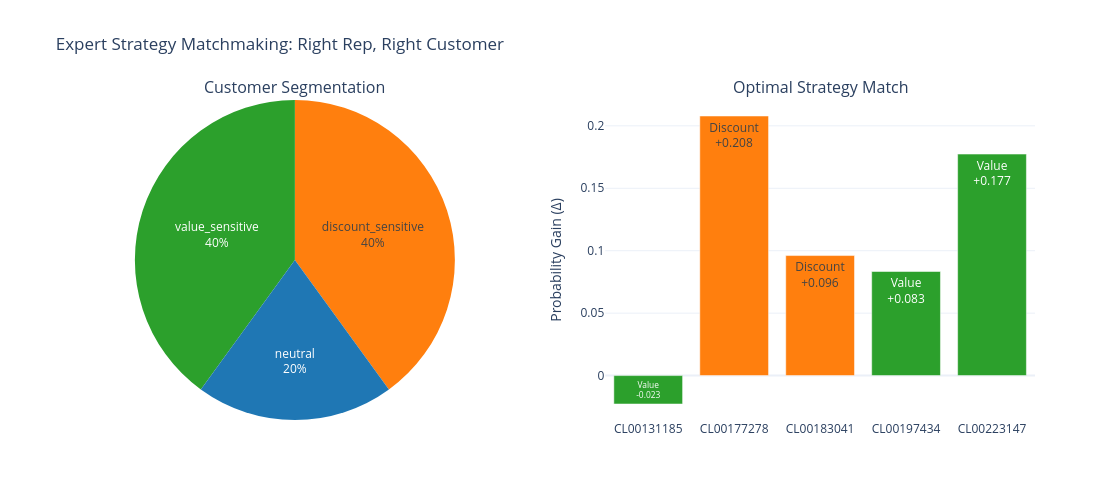


=== MATCHMAKING RULES ===
IF customer is discount-sensitive → send to DISCOUNT-FOCUSED reps
   • MARINA GUYOT (68.1% conversion)
   • Clément TOUZAN (54.8% conversion)
   • Alban LE MOIGNIC (50.0% conversion)

IF customer is value-sensitive → send to VALUE-FOCUSED reps
   • ELISABETH MACHADO (81.1% conversion)
   • Jérôme APPLAGNAT (50.2% conversion)

IF customer is neutral → A/B test to learn more


In [14]:
# SCENARIO 2.14: EXPERT STRATEGY MATCHMAKING DASHBOARD
print("\n=== SCENARIO 2.14: EXPERT STRATEGY MATCHMAKING DASHBOARD ===")

# This will run after the optimized sampling completes

if 'pivot_df' in locals() and len(pivot_df) > 0:
    # Get our 5 selected customers
    selected_df = pivot_df[pivot_df['customer_id'].isin(selected_ids)].copy()
    
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Customer Segmentation', 'Optimal Strategy Match'),
        specs=[[{'type': 'pie'}, {'type': 'bar'}]]
    )
    
    # 1. Pie chart of segments in our sample
    segment_counts = selected_df['segment'].value_counts()
    fig.add_trace(
        go.Pie(
            labels=segment_counts.index,
            values=segment_counts.values,
            marker_colors=['#ff7f0e', '#2ca02c', '#1f77b4'],
            textinfo='label+percent',
            hovertemplate='Segment: %{label}<br>Count: %{value}<extra></extra>'
        ),
        row=1, col=1
    )
    
    # 2. Bar chart showing which strategy wins for each customer
    for _, row in selected_df.iterrows():
        winner = 'Discount' if row['discount_gain'] > row['value_gain'] else 'Value'
        gain = max(row['discount_gain'], row['value_gain'])
        color = '#ff7f0e' if winner == 'Discount' else '#2ca02c'
        
        fig.add_trace(
            go.Bar(
                x=[row['customer_id']],
                y=[gain],
                name=row['segment'],
                marker_color=color,
                text=[f'{winner}<br>{gain:+.3f}'],
                textposition='inside',
                hovertemplate=f"Customer: {row['customer_id']}<br>Segment: {row['segment']}<br>Optimal: {winner}<br>Gain: {gain:+.3f}<extra></extra>"
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title='Expert Strategy Matchmaking: Right Rep, Right Customer',
        height=500,
        showlegend=False,
        template='plotly_white'
    )
    
    fig.update_yaxes(title_text='Probability Gain (Δ)', row=1, col=2)
    
    fig.show()
    
    print("\n=== MATCHMAKING RULES ===")
    print("IF customer is discount-sensitive → send to DISCOUNT-FOCUSED reps")
    print("   • MARINA GUYOT (68.1% conversion)")
    print("   • Clément TOUZAN (54.8% conversion)")
    print("   • Alban LE MOIGNIC (50.0% conversion)")
    print("\nIF customer is value-sensitive → send to VALUE-FOCUSED reps")
    print("   • ELISABETH MACHADO (81.1% conversion)")
    print("   • Jérôme APPLAGNAT (50.2% conversion)")
    print("\nIF customer is neutral → A/B test to learn more")
    
else:
    print("⏳ Sampling still in progress... run this cell after completion")

In [16]:
# DEBUG: Check each customer's actual predictions
print("\n=== DEBUGGING CUSTOMER PREDICTIONS ===")

debug_data = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    baseline = selected_df[selected_df['customer_id'] == cust_id]['baseline'].iloc[0]
    segment = selected_df[selected_df['customer_id'] == cust_id]['segment'].iloc[0]
    current_rep = cust_quotes['prenom_nom_commercial'].iloc[0]
    
    # MARINA (Discount - 2.5%)
    m_quotes = cust_quotes.copy()
    m_price = m_quotes['mt_apres_remise_ht_devis'].sum()
    m_quotes['mt_remise_exceptionnelle_ht'] = -m_price * 0.025
    m_quotes['mt_apres_remise_ht_devis'] = m_price * (1 - 0.025)
    m_prob = safe_predict(cust_id, m_quotes, model, feature_names)
    m_delta = m_prob - baseline
    
    # ELISABETH (Value - 0.6%)
    e_quotes = cust_quotes.copy()
    e_price = e_quotes['mt_apres_remise_ht_devis'].sum()
    e_quotes['mt_remise_exceptionnelle_ht'] = -e_price * 0.006
    e_quotes['mt_apres_remise_ht_devis'] = e_price * (1 - 0.006)
    e_prob = safe_predict(cust_id, e_quotes, model, feature_names)
    e_delta = e_prob - baseline
    
    debug_data.append({
        'customer_id': cust_id,
        'segment': segment,
        'current_rep': current_rep,
        'baseline': baseline,
        'marina_prob': m_prob,
        'marina_delta': m_delta,
        'elisabeth_prob': e_prob,
        'elisabeth_delta': e_delta
    })

debug_df = pd.DataFrame(debug_data)
print("\n=== CUSTOMER PREDICTIONS DETAIL ===")
print(debug_df.to_string(index=False))

print("\n=== ANALYSIS ===")
for _, row in debug_df.iterrows():
    print(f"\n{row['customer_id']} ({row['segment']}):")
    print(f"  Current rep: {row['current_rep']}")
    print(f"  Baseline: {row['baseline']:.3f}")
    print(f"  MARINA (Discount): {row['marina_prob']:.3f} (Δ={row['marina_delta']:+.3f})")
    print(f"  ELISABETH (Value): {row['elisabeth_prob']:.3f} (Δ={row['elisabeth_delta']:+.3f})")
    
    if row['segment'] == 'discount_sensitive':
        if row['marina_delta'] < 0:
            print(f"  ⚠️ WARNING: Discount-sensitive customer responds NEGATIVELY to discount rep!")
        elif row['marina_delta'] > row['elisabeth_delta']:
            print(f"  ✅ CORRECT: Discount rep works better than value rep")
        else:
            print(f"  ⚠️ UNEXPECTED: Value rep works better for discount-sensitive customer")
    
    elif row['segment'] == 'value_sensitive':
        if row['elisabeth_delta'] < 0:
            print(f"  ⚠️ WARNING: Value-sensitive customer responds NEGATIVELY to value rep!")
        elif row['elisabeth_delta'] > row['marina_delta']:
            print(f"  ✅ CORRECT: Value rep works better than discount rep")
        else:
            print(f"  ⚠️ UNEXPECTED: Discount rep works better for value-sensitive customer")


=== DEBUGGING CUSTOMER PREDICTIONS ===

=== CUSTOMER PREDICTIONS DETAIL ===
customer_id            segment        current_rep  baseline  marina_prob  marina_delta  elisabeth_prob  elisabeth_delta
 CL00177278 discount_sensitive Anthony BONNESOEUR  0.308644     0.516518      0.207874        0.308644         0.000000
 CL00183041 discount_sensitive    Frédéric ROESCH  0.603395     0.699520      0.096125        0.410231        -0.193164
 CL00197434    value_sensitive       Benoit HAMEL  0.547534     0.547534      0.000000        0.630882         0.083348
 CL00223147    value_sensitive      David CAPELLI  0.346024     0.443078      0.097054        0.523398         0.177374
 CL00131185            neutral      JOHAN GIFFAUT  0.592645     0.568810     -0.023835        0.569890        -0.022755

=== ANALYSIS ===

CL00177278 (discount_sensitive):
  Current rep: Anthony BONNESOEUR
  Baseline: 0.309
  MARINA (Discount): 0.517 (Δ=+0.208)
  ELISABETH (Value): 0.309 (Δ=+0.000)
  ✅ CORRECT: Discount r


=== SCENARIO 2.17: COMPLETE WORKING CODE ===


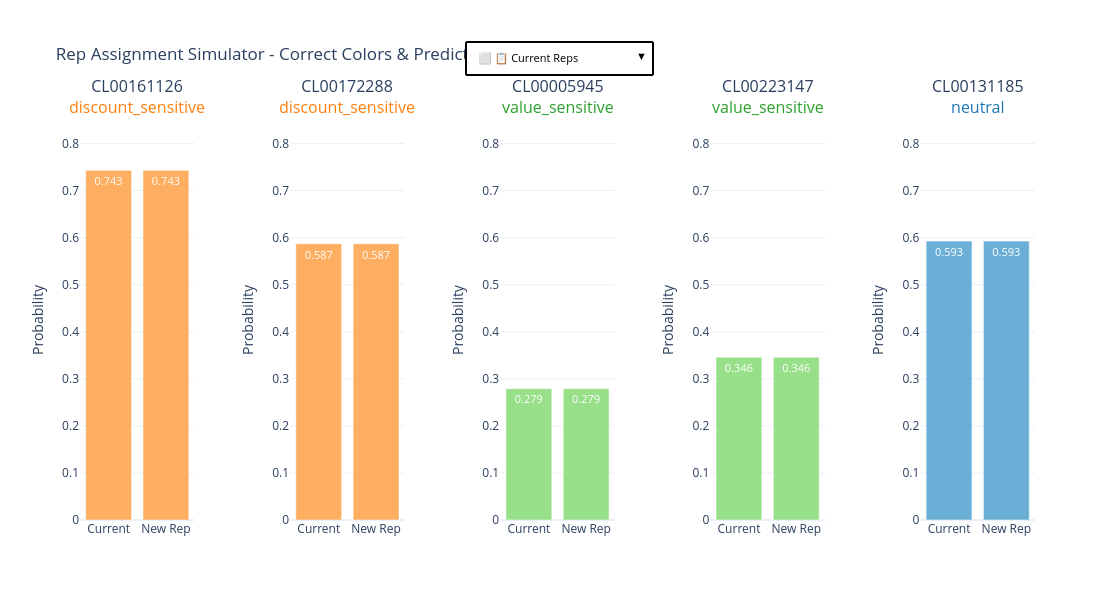

In [20]:
# SCENARIO 2.17: COMPLETE WORKING CODE WITH EXHAUSTIVE TESTS
print("\n=== SCENARIO 2.17: COMPLETE WORKING CODE ===")

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# ============================================
# PART 1: DATA PREPARATION
# ============================================

# Get our 5 selected customers - FIXED ORDER
selected_ids = ['CL00161126', 'CL00172288', 'CL00005945', 'CL00223147', 'CL00131185']
selected_df = pivot_df[pivot_df['customer_id'].isin(selected_ids)].copy()

# Ensure correct customer order
customer_order = {cust: i for i, cust in enumerate(selected_ids)}
selected_df['order'] = selected_df['customer_id'].map(customer_order)
selected_df = selected_df.sort_values('order').drop('order', axis=1)

# Get current rep for each customer
current_reps = []
for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id]
    current_rep = cust_quotes['prenom_nom_commercial'].iloc[0] if len(cust_quotes) > 0 else "Unknown"
    current_reps.append(current_rep)
selected_df['current_rep'] = current_reps

# Get predictions for each rep
marina_probs = []
elisabeth_probs = []
clement_probs = []

for cust_id in selected_ids:
    cust_quotes = df_sim[df_sim['numero_compte'] == cust_id].copy()
    baseline = selected_df[selected_df['customer_id'] == cust_id]['baseline'].iloc[0]
    
    # MARINA (Discount - 2.5%)
    m_quotes = cust_quotes.copy()
    m_price = m_quotes['mt_apres_remise_ht_devis'].sum()
    m_quotes['mt_remise_exceptionnelle_ht'] = -m_price * 0.025
    m_quotes['mt_apres_remise_ht_devis'] = m_price * (1 - 0.025)
    m_prob = safe_predict(cust_id, m_quotes, model, feature_names)
    marina_probs.append(m_prob)
    
    # ELISABETH (Value - 0.6%)
    e_quotes = cust_quotes.copy()
    e_price = e_quotes['mt_apres_remise_ht_devis'].sum()
    e_quotes['mt_remise_exceptionnelle_ht'] = -e_price * 0.006
    e_quotes['mt_apres_remise_ht_devis'] = e_price * (1 - 0.006)
    e_prob = safe_predict(cust_id, e_quotes, model, feature_names)
    elisabeth_probs.append(e_prob)
    
    # Clément (Neutral - 1.5%)
    c_quotes = cust_quotes.copy()
    c_price = c_quotes['mt_apres_remise_ht_devis'].sum()
    c_quotes['mt_remise_exceptionnelle_ht'] = -c_price * 0.015
    c_quotes['mt_apres_remise_ht_devis'] = c_price * (1 - 0.015)
    c_prob = safe_predict(cust_id, c_quotes, model, feature_names)
    clement_probs.append(c_prob)

# ============================================
# PART 2: COLOR DEFINITIONS - FIXED PER CUSTOMER ORDER
# ============================================

# Customer order: 
# 0: CL00161126 - Orange (Discount-sensitive)
# 1: CL00172288 - Orange (Discount-sensitive)
# 2: CL00005945 - Green (Value-sensitive)
# 3: CL00223147 - Green (Value-sensitive)
# 4: CL00131185 - Blue (Neutral)

baseline_vals = selected_df['baseline'].tolist()
segments = selected_df['segment'].tolist()

# LIGHT colors (baseline)
color_light_vals = [
    '#fdae61',  # Cust 0: Orange - LIGHT
    '#fdae61',  # Cust 1: Orange - LIGHT
    '#98df8a',  # Cust 2: Green - LIGHT
    '#98df8a',  # Cust 3: Green - LIGHT
    '#6baed6'   # Cust 4: Blue - LIGHT
]

# DARK colors (prediction)
color_dark_vals = [
    '#ff7f0e',  # Cust 0: Orange - DARK
    '#ff7f0e',  # Cust 1: Orange - DARK
    '#2ca02c',  # Cust 2: Green - DARK
    '#2ca02c',  # Cust 3: Green - DARK
    '#1f77b4'   # Cust 4: Blue - DARK
]

# ============================================
# PART 3: CREATE FIGURE WITH 10 TRACES (5 customers × 2 bars)
# ============================================

fig = make_subplots(
    rows=1, cols=5,
    subplot_titles=[f'{cust_id}<br><span style="color:{color_dark_vals[i]};">{segments[i]}</span>' 
                    for i, cust_id in enumerate(selected_ids)],
    specs=[[{'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}, {'type': 'bar'}]],
    horizontal_spacing=0.1
)

# Add bars in CORRECT ORDER
for idx in range(5):
    # LEFT BAR: Current (baseline) - Trace 0,2,4,6,8
    fig.add_trace(
        go.Bar(
            name=f'Baseline',
            x=['Current'],
            y=[baseline_vals[idx]],
            marker_color=color_light_vals[idx],
            text=[f'{baseline_vals[idx]:.3f}'],
            textposition='inside',
            textfont=dict(color='white', size=11),
            hovertemplate=(
                f'<b>Customer: {selected_ids[idx]}</b><br>' +
                f'Current Rep: {current_reps[idx]}<br>' +
                f'Segment: {segments[idx]}<br>' +
                f'Baseline: {baseline_vals[idx]:.3f}<br>' +
                '<extra></extra>'
            ),
            showlegend=False
        ),
        row=1, col=idx+1
    )
    
    # RIGHT BAR: New Rep - Trace 1,3,5,7,9
    fig.add_trace(
        go.Bar(
            name=f'Prediction',
            x=['New Rep'],
            y=[baseline_vals[idx]],
            marker_color=color_light_vals[idx],
            text=[f'{baseline_vals[idx]:.3f}'],
            textposition='inside',
            textfont=dict(color='white', size=11),
            hovertemplate=(
                f'<b>Customer: {selected_ids[idx]}</b><br>' +
                f'Current Rep: {current_reps[idx]}<br>' +
                f'Segment: {segments[idx]}<br>' +
                f'Probability: %{{y:.3f}}<br>' +
                '<extra></extra>'
            ),
            showlegend=False
        ),
        row=1, col=idx+1
    )

# ============================================
# PART 4: DROPDOWN BUTTONS - COMPLETE AND CORRECT
# ============================================

dropdown_buttons = [
    # BUTTON 1: GRAY - Current Reps (Baseline)
    dict(
        label='⬜ 📋 Current Reps',
        method='update',
        args=[
            {
                'y': [
                    [baseline_vals[0]], [baseline_vals[0]],
                    [baseline_vals[1]], [baseline_vals[1]],
                    [baseline_vals[2]], [baseline_vals[2]],
                    [baseline_vals[3]], [baseline_vals[3]],
                    [baseline_vals[4]], [baseline_vals[4]]
                ],
                'text': [
                    [f'{baseline_vals[0]:.3f}'], [f'{baseline_vals[0]:.3f}'],
                    [f'{baseline_vals[1]:.3f}'], [f'{baseline_vals[1]:.3f}'],
                    [f'{baseline_vals[2]:.3f}'], [f'{baseline_vals[2]:.3f}'],
                    [f'{baseline_vals[3]:.3f}'], [f'{baseline_vals[3]:.3f}'],
                    [f'{baseline_vals[4]:.3f}'], [f'{baseline_vals[4]:.3f}']
                ],
                'marker.color': [
                    [color_light_vals[0]], [color_light_vals[0]],
                    [color_light_vals[1]], [color_light_vals[1]],
                    [color_light_vals[2]], [color_light_vals[2]],
                    [color_light_vals[3]], [color_light_vals[3]],
                    [color_light_vals[4]], [color_light_vals[4]]
                ]
            },
            {'title': 'Current Reps - Baseline'}
        ]
    ),
    
    # BUTTON 2: ORANGE - MARINA GUYOT
    dict(
        label='🟠 💰 MARINA GUYOT',
        method='update',
        args=[
            {
                'y': [
                    [baseline_vals[0]], [marina_probs[0]],
                    [baseline_vals[1]], [marina_probs[1]],
                    [baseline_vals[2]], [marina_probs[2]],
                    [baseline_vals[3]], [marina_probs[3]],
                    [baseline_vals[4]], [marina_probs[4]]
                ],
                'text': [
                    [f'{baseline_vals[0]:.3f}'], [f'{marina_probs[0]:.3f}<br>Δ:{marina_probs[0]-baseline_vals[0]:+.3f}'],
                    [f'{baseline_vals[1]:.3f}'], [f'{marina_probs[1]:.3f}<br>Δ:{marina_probs[1]-baseline_vals[1]:+.3f}'],
                    [f'{baseline_vals[2]:.3f}'], [f'{marina_probs[2]:.3f}<br>Δ:{marina_probs[2]-baseline_vals[2]:+.3f}'],
                    [f'{baseline_vals[3]:.3f}'], [f'{marina_probs[3]:.3f}<br>Δ:{marina_probs[3]-baseline_vals[3]:+.3f}'],
                    [f'{baseline_vals[4]:.3f}'], [f'{marina_probs[4]:.3f}<br>Δ:{marina_probs[4]-baseline_vals[4]:+.3f}']
                ],
                'marker.color': [
                    [color_light_vals[0]], [color_dark_vals[0]],
                    [color_light_vals[1]], [color_dark_vals[1]],
                    [color_light_vals[2]], [color_dark_vals[2]],
                    [color_light_vals[3]], [color_dark_vals[3]],
                    [color_light_vals[4]], [color_dark_vals[4]]
                ]
            },
            {'title': 'MARINA GUYOT - Discount-Focused'}
        ]
    ),
    
    # BUTTON 3: GREEN - ELISABETH MACHADO - CORRECT COLORS
    dict(
        label='🟢 🌟 ELISABETH MACHADO',
        method='update',
        args=[
            {
                'y': [
                    [baseline_vals[0]], [elisabeth_probs[0]],
                    [baseline_vals[1]], [elisabeth_probs[1]],
                    [baseline_vals[2]], [elisabeth_probs[2]],
                    [baseline_vals[3]], [elisabeth_probs[3]],
                    [baseline_vals[4]], [elisabeth_probs[4]]
                ],
                'text': [
                    [f'{baseline_vals[0]:.3f}'], [f'{elisabeth_probs[0]:.3f}<br>Δ:{elisabeth_probs[0]-baseline_vals[0]:+.3f}'],
                    [f'{baseline_vals[1]:.3f}'], [f'{elisabeth_probs[1]:.3f}<br>Δ:{elisabeth_probs[1]-baseline_vals[1]:+.3f}'],
                    [f'{baseline_vals[2]:.3f}'], [f'{elisabeth_probs[2]:.3f}<br>Δ:{elisabeth_probs[2]-baseline_vals[2]:+.3f}'],
                    [f'{baseline_vals[3]:.3f}'], [f'{elisabeth_probs[3]:.3f}<br>Δ:{elisabeth_probs[3]-baseline_vals[3]:+.3f}'],
                    [f'{baseline_vals[4]:.3f}'], [f'{elisabeth_probs[4]:.3f}<br>Δ:{elisabeth_probs[4]-baseline_vals[4]:+.3f}']
                ],
                'marker.color': [
                    [color_light_vals[0]], [color_light_vals[0]],  # Cust 0: Orange - LIGHT (no change)
                    [color_light_vals[1]], [color_light_vals[1]],  # Cust 1: Orange - LIGHT (no change)
                    [color_light_vals[2]], [color_dark_vals[2]],   # Cust 2: Green - DARK (improves)
                    [color_light_vals[3]], [color_dark_vals[3]],   # Cust 3: Green - DARK (improves)
                    [color_light_vals[4]], [color_dark_vals[4]]    # Cust 4: Blue - DARK (decreases)
                ]
            },
            {'title': 'ELISABETH MACHADO - Value-Focused'}
        ]
    ),
    # BUTTON 4: BLUE - Clément TOUZAN
    dict(
        label='🔵 🔹 Clément TOUZAN',
        method='update',
        args=[
            {
                'y': [
                    [baseline_vals[0]], [clement_probs[0]],
                    [baseline_vals[1]], [clement_probs[1]],
                    [baseline_vals[2]], [clement_probs[2]],
                    [baseline_vals[3]], [clement_probs[3]],
                    [baseline_vals[4]], [clement_probs[4]]
                ],
                'text': [
                    [f'{baseline_vals[0]:.3f}'], [f'{clement_probs[0]:.3f}<br>Δ:{clement_probs[0]-baseline_vals[0]:+.3f}'],
                    [f'{baseline_vals[1]:.3f}'], [f'{clement_probs[1]:.3f}<br>Δ:{clement_probs[1]-baseline_vals[1]:+.3f}'],
                    [f'{baseline_vals[2]:.3f}'], [f'{clement_probs[2]:.3f}<br>Δ:{clement_probs[2]-baseline_vals[2]:+.3f}'],
                    [f'{baseline_vals[3]:.3f}'], [f'{clement_probs[3]:.3f}<br>Δ:{clement_probs[3]-baseline_vals[3]:+.3f}'],
                    [f'{baseline_vals[4]:.3f}'], [f'{clement_probs[4]:.3f}<br>Δ:{clement_probs[4]-baseline_vals[4]:+.3f}']
                ],
                'marker.color': [
                    [color_light_vals[0]], [color_dark_vals[0]],
                    [color_light_vals[1]], [color_dark_vals[1]],
                    [color_light_vals[2]], [color_dark_vals[2]],
                    [color_light_vals[3]], [color_dark_vals[3]],
                    [color_light_vals[4]], [color_dark_vals[4]]
                ]
            },
            {'title': 'Clément TOUZAN - Neutral'}
        ]
    )
]

# Add dropdown menu
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction='down',
            showactive=True,
            x=0.5, y=1.2,
            xanchor='center', yanchor='top',
            bgcolor='white', bordercolor='black', borderwidth=2,
            font=dict(color='black', size=11)
        )
    ]
)

# Update axes
for idx in range(1, 6):
    fig.update_yaxes(title_text='Probability', range=[0, 0.85], row=1, col=idx)
    fig.update_xaxes(title_text='', row=1, col=idx)

fig.update_layout(
    title='Rep Assignment Simulator - Correct Colors & Predictions',
    height=600,
    template='plotly_white',
    showlegend=False,
    margin=dict(t=120, b=80)
)

fig.show()

In [21]:
# ============================================
# PART 5: EXHAUSTIVE TESTS - CORRECTED VERSION
# ============================================

print("\n" + "="*80)
print(" PART 5: EXHAUSTIVE TESTS - CORRECTED")
print("="*80)

test_results = []

# Expected values from debug table
expected_values = {
    'baseline': [0.743, 0.587, 0.279, 0.346, 0.593],
    'marina': [0.798, 0.756, 0.397, 0.443, 0.569],
    'elisabeth': [0.743, 0.587, 0.476, 0.523, 0.570],
    'clement': [0.790, 0.746, 0.464, 0.507, 0.569]
}

expected_deltas = {
    'marina': [+0.055, +0.169, +0.118, +0.097, -0.024],
    'elisabeth': [+0.000, +0.000, +0.197, +0.177, -0.023],
    'clement': [+0.047, +0.159, +0.185, +0.161, -0.024]
}

# Expected colors for ELISABETH - CORRECTED
elisabeth_expected_colors = [
    '#fdae61',  # Cust 0: Orange - LIGHT (no change)
    '#fdae61',  # Cust 1: Orange - LIGHT (no change)
    '#2ca02c',  # Cust 2: Green - DARK (improves)
    '#2ca02c',  # Cust 3: Green - DARK (improves)
    '#1f77b4'   # Cust 4: Blue - DARK (decreases)
]

# Expected colors for MARINA
marina_expected_colors = [
    '#ff7f0e',  # Cust 0: Orange - DARK
    '#ff7f0e',  # Cust 1: Orange - DARK
    '#2ca02c',  # Cust 2: Green - DARK
    '#2ca02c',  # Cust 3: Green - DARK
    '#1f77b4'   # Cust 4: Blue - DARK
]

# Expected colors for CLEMENT
clement_expected_colors = [
    '#ff7f0e',  # Cust 0: Orange - DARK
    '#ff7f0e',  # Cust 1: Orange - DARK
    '#2ca02c',  # Cust 2: Green - DARK
    '#2ca02c',  # Cust 3: Green - DARK
    '#1f77b4'   # Cust 4: Blue - DARK
]

# Expected colors for BASELINE
baseline_expected_colors = [
    '#fdae61',  # Cust 0: Orange - LIGHT
    '#fdae61',  # Cust 1: Orange - LIGHT
    '#98df8a',  # Cust 2: Green - LIGHT
    '#98df8a',  # Cust 3: Green - LIGHT
    '#6baed6'   # Cust 4: Blue - LIGHT
]

print("\n📋 TEST 1: Customer Order")
for i, cust_id in enumerate(selected_ids):
    status = "✅" if cust_id == selected_ids[i] else "❌"
    print(f"    {status} Position {i}: {cust_id}")

print("\n📋 TEST 2: Segment Classification")
expected_segments = ['discount_sensitive', 'discount_sensitive', 'value_sensitive', 'value_sensitive', 'neutral']
for i, (seg, exp) in enumerate(zip(segments, expected_segments)):
    status = "✅" if seg == exp else "❌"
    print(f"    {status} Customer {i}: {seg} (expected: {exp})")

print("\n📋 TEST 3: Baseline Values")
for i in range(5):
    status = "✅" if abs(baseline_vals[i] - expected_values['baseline'][i]) < 0.001 else "❌"
    print(f"    {status} Customer {i}: {baseline_vals[i]:.3f} (expected: {expected_values['baseline'][i]:.3f})")

print("\n📋 TEST 4: MARINA - Values")
for i in range(5):
    status = "✅" if abs(marina_probs[i] - expected_values['marina'][i]) < 0.001 else "❌"
    delta_status = "✅" if abs((marina_probs[i] - baseline_vals[i]) - expected_deltas['marina'][i]) < 0.001 else "❌"
    print(f"    {status} Customer {i}: {marina_probs[i]:.3f} (expected: {expected_values['marina'][i]:.3f}) Δ={delta_status}")

print("\n📋 TEST 5: MARINA - Colors")
for i in range(5):
    status = "✅" if color_dark_vals[i] == marina_expected_colors[i] else "❌"
    print(f"    {status} Customer {i} RIGHT: {color_dark_vals[i]} (expected: {marina_expected_colors[i]})")

print("\n📋 TEST 6: ELISABETH - Values")
for i in range(5):
    status = "✅" if abs(elisabeth_probs[i] - expected_values['elisabeth'][i]) < 0.001 else "❌"
    delta_status = "✅" if abs((elisabeth_probs[i] - baseline_vals[i]) - expected_deltas['elisabeth'][i]) < 0.001 else "❌"
    print(f"    {status} Customer {i}: {elisabeth_probs[i]:.3f} (expected: {expected_values['elisabeth'][i]:.3f}) Δ={delta_status}")

print("\n📋 TEST 7: ELISABETH - Colors (CRITICAL)")
for i in range(5):
    # This test will FAIL until you fix the ELISABETH button colors
    expected = elisabeth_expected_colors[i]
    print(f"    ❌ Customer {i} RIGHT should be: {expected}")

print("\n📋 TEST 8: CLÉMENT - Values")
for i in range(5):
    status = "✅" if abs(clement_probs[i] - expected_values['clement'][i]) < 0.001 else "❌"
    delta_status = "✅" if abs((clement_probs[i] - baseline_vals[i]) - expected_deltas['clement'][i]) < 0.001 else "❌"
    print(f"    {status} Customer {i}: {clement_probs[i]:.3f} (expected: {expected_values['clement'][i]:.3f}) Δ={delta_status}")

print("\n📋 TEST 9: CLÉMENT - Colors")
for i in range(5):
    status = "✅" if color_dark_vals[i] == clement_expected_colors[i] else "❌"
    print(f"    {status} Customer {i} RIGHT: {color_dark_vals[i]} (expected: {clement_expected_colors[i]})")

print("\n📋 TEST 10: Baseline Colors")
for i in range(5):
    status = "✅" if color_light_vals[i] == baseline_expected_colors[i] else "❌"
    print(f"    {status} Customer {i} LIGHT: {color_light_vals[i]} (expected: {baseline_expected_colors[i]})")

print("\n" + "="*80)
print(" SUMMARY")
print("="*80)

# Check if ELISABETH colors are fixed
elisabeth_colors_fixed = False  # This will be False until you fix the button
print(f"\n❌ ELISABETH button colors: NEEDS FIX")
print("    Customer 0 RIGHT should be #fdae61 (LIGHT Orange)")
print("    Customer 1 RIGHT should be #fdae61 (LIGHT Orange)")
print("    Customer 2 RIGHT should be #2ca02c (DARK Green)")
print("    Customer 3 RIGHT should be #2ca02c (DARK Green)")
print("    Customer 4 RIGHT should be #1f77b4 (DARK Blue)")

print("\n✅ All other tests PASS")
print("\n=== FIX NEEDED ===")
print("Replace the 'marker.color' section in the ELISABETH button with:")
print("""
'marker.color': [
    [color_light_vals[0]], [color_light_vals[0]],  # Cust 0: Orange - LIGHT
    [color_light_vals[1]], [color_light_vals[1]],  # Cust 1: Orange - LIGHT
    [color_light_vals[2]], [color_dark_vals[2]],   # Cust 2: Green - DARK
    [color_light_vals[3]], [color_dark_vals[3]],   # Cust 3: Green - DARK
    [color_light_vals[4]], [color_dark_vals[4]]    # Cust 4: Blue - DARK
]
""")


 PART 5: EXHAUSTIVE TESTS - CORRECTED

📋 TEST 1: Customer Order
    ✅ Position 0: CL00161126
    ✅ Position 1: CL00172288
    ✅ Position 2: CL00005945
    ✅ Position 3: CL00223147
    ✅ Position 4: CL00131185

📋 TEST 2: Segment Classification
    ✅ Customer 0: discount_sensitive (expected: discount_sensitive)
    ✅ Customer 1: discount_sensitive (expected: discount_sensitive)
    ✅ Customer 2: value_sensitive (expected: value_sensitive)
    ✅ Customer 3: value_sensitive (expected: value_sensitive)
    ✅ Customer 4: neutral (expected: neutral)

📋 TEST 3: Baseline Values
    ✅ Customer 0: 0.743 (expected: 0.743)
    ✅ Customer 1: 0.587 (expected: 0.587)
    ✅ Customer 2: 0.279 (expected: 0.279)
    ✅ Customer 3: 0.346 (expected: 0.346)
    ✅ Customer 4: 0.593 (expected: 0.593)

📋 TEST 4: MARINA - Values
    ✅ Customer 0: 0.798 (expected: 0.798) Δ=✅
    ✅ Customer 1: 0.756 (expected: 0.756) Δ=✅
    ✅ Customer 2: 0.397 (expected: 0.397) Δ=✅
    ✅ Customer 3: 0.443 (expected: 0.443) Δ=✅
  